In [3]:
#!/usr/bin/env python
import lz4.frame as lz4f
import cloudpickle
import json
import pprint
import numpy as np
import awkward
np.seterr(divide='ignore', invalid='ignore', over='ignore')
from coffea.arrays import Initialize
from coffea import hist, processor
from coffea.util import load, save
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty, JetTransformer, JetResolution, JetResolutionScaleFactor
from optparse import OptionParser
from uproot_methods import TVector2Array, TLorentzVectorArray

### Baseline Event selection 2018

general:

1. $E^T_{miss}$≥ 100 GeV
2. no loose $\gamma$
3. 1(0) tight(loose) e($\mu$) or 1(0) tight(loose) ($\mu$)(e)
4. ele triggers for e events
5. $\mu$ triggers for ($\mu$) events
6. $\delta$φ(leading AK4 jet, MET)> 1.5
7. $\delta$R(leading AK4 jet, $e$ / $\mu$)< 3.4

In [47]:
class testprocessor(processor.ProcessorABC):
    def __init__(self):
        


        self._accumulator = processor.dict_accumulator({ 
#             'mT': hist.Hist(
#                 'Events',
#                 hist.Cat('dataset', 'Dataset'),
#                 hist.Cat('region', 'Region'),
#                 hist.Bin('mT','Transverse Mass',100,0,600)),
            
            'ele_pt': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Leading $e_{pT}$ GeV', 40,0,200)),
            
            'ele_eta': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('eta', 'Leading $e_{\eta}$ ', 10,-2.5, 2.5)),
        
            'mu_pt': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Leading $\mu_{pT}$ GeV', 40,0,200)),
            
            'mu_eta': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('eta', 'Leading $\mu_{\eta}$ GeV', 10,-2.5, 2.5))
        }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
 

        ## This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()


        dataset = events.metadata['dataset']
        
        
        Electron = events.Electron
        LeadingEle = Electron[Electron.pt.argmax()]
        LeadingEle = LeadingEle[((LeadingEle.pt>40)&(abs(LeadingEle.eta)<1.4442)&(abs(LeadingEle.dxy)<0.05)&(abs(LeadingEle.dz)<0.1)&(LeadingEle.cutBased==4)) | ((LeadingEle.pt>40)&(abs(LeadingEle.eta)>1.5660)&(abs(LeadingEle.eta)<2.5)&(abs(LeadingEle.dxy)<0.1)&(abs(LeadingEle.dz)<0.2)&(LeadingEle.cutBased==4))]
        output['ele_pt'].fill(dataset=dataset,
                             region='everthing',
                             pT = LeadingEle.pt.flatten())
        output['ele_eta'].fill(dataset=dataset,
                             region='everthing',
                             eta = LeadingEle.eta.flatten())
        
        Muon = events.Muon
        LeadingMu = Muon[Muon.pt.argmax()]    
        LeadingMu = LeadingMu[(LeadingMu.pt>30)&(abs(LeadingMu.eta)<2.4)&(LeadingMu.tightId)&(LeadingMu.pfRelIso04_all<0.15)]
        output['mu_pt'].fill(dataset=dataset,
                             region='everthing',
                             pT = LeadingMu.pt.flatten())
        output['mu_eta'].fill(dataset=dataset,
                             region='everthing',
                             eta = LeadingMu.eta.flatten())
        
        return output   
    def postprocess(self, accumulator):
        return accumulator    

In [48]:
fileset = {'EGamma':
[
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5077.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5078.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5079.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5080.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5081.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5082.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5083.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5084.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5085.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5086.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5087.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5088.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5089.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5090.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5091.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5092.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5093.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5094.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5095.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5096.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5097.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5098.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5099.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5100.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5101.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5102.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5103.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5104.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5105.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5106.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5107.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5108.root"
        ]}
#Run Coffea code using uproot
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=testprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True, 'nano':True},
                                 )

In [ ]:
if __name__ == '__main__':
    parser = OptionParser()
    parser.add_option('-y', '--year', help='year', dest='year')
    (options, args) = parser.parse_args()


    with open('metadata/'+options.year+'.json') as fin:
        samplefiles = json.load(fin)
        xsec = {k: v['xs'] for k,v in samplefiles.items()}

    corrections = load('data/corrections.coffea')
    ids         = load('data/ids.coffea')
    common      = load('data/common.coffea')

    processor_instance=AnalysisProcessor(year=options.year,
                                         xsec=xsec,
                                         corrections=corrections,
                                         ids=ids,
                                         common=common)

    save(processor_instance, 'data/darkhiggs'+options.year+'.processor')

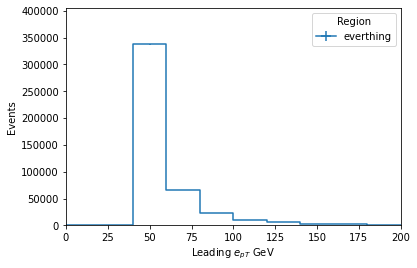

In [43]:
hist.plot1d(output['ele_pt'].integrate('dataset')) # before

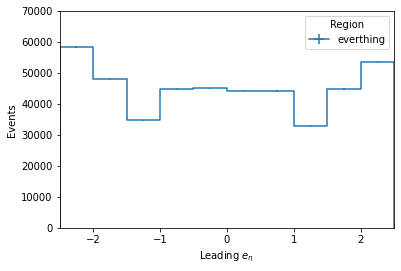

In [44]:
hist.plot1d(output['ele_eta'].integrate('dataset')) #after

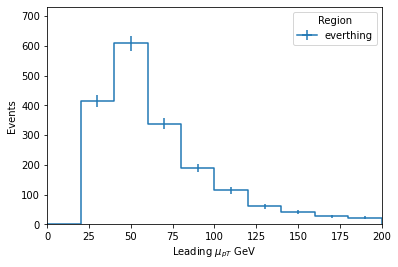

In [45]:
hist.plot1d(output['mu_pt'].integrate('dataset')) #after

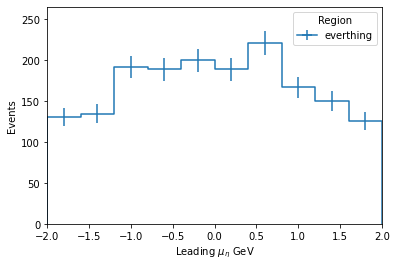

In [46]:
hist.plot1d(output['mu_eta'].integrate('dataset')) #after